### Project : Casual Inference for PA impact report

##### Objective: To perform a structured time-series analysis with causal inference to determine if the introduction of Marketing campaigns was the cause for a increase in revenue.
#####  Scenario: The stackholders in Retail industry invested some money in on-field marketing campaigns in some stores in order to increase the sales. Now I need the find the whether the marketing campaign impact on the revenue. The sales data is collected every week 
#####  Tools Used: Python, Pandas, Matplotlib, Seaborn, Causal Impact
#####  Skills Demonstrated: Exploratory Data Analysis, Bayesian Structural Time Series, Causal Inference, Data Visualization


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, sys, glob
from datetime import datetime, date
import pyodbc
from urllib.parse import quote_plus
from sqlalchemy import create_engine, event
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import datetime as dt
from getdata import GETDATA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('Input_data/Nova Stock FY21 H1.xlsx')

In [3]:
DB = GETDATA(DBconfigfilepath='dbconfig.env')
max_date = datetime(2023, 3, 20).strftime('%Y-%m-%d-%H:%M:%S')
data = DB.pull_DB_data(max_date, PA_type = 'RMPA')

In [5]:
data = data.loc[data['Sales_Date'] <= '2022-12-31'].reset_index(drop=True)

In [6]:
print(data['Sales_Date'].min())
print(data['Sales_Date'].max())

2021-07-01 00:00:00
2022-12-31 00:00:00


In [8]:
data = data.groupby(['Sales_Date', 'Outlet_ID', 'Store', 'Super_Division']).sum().reset_index()

In [9]:
data = data.loc[(data['Sales_Date'].dt.day_name() == 'Friday') | (data['Sales_Date'].dt.day_name() == 'Saturday')].reset_index(drop=True)

In [11]:
data = (data.set_index("Sales_Date").groupby(['Outlet_ID', 'Store', 'Super_Division', pd.Grouper(freq='W')])["Rslr Sales Quantity", "Rslr Sales Amount"].sum().astype(int).reset_index())

In [13]:
def PADDING_DATA(data):
    continuous_data = pd.DataFrame()
    stores = data['Outlet_ID'].unique()
    products= data['Super_Division'].unique()
    least_date = data['Sales_Date'].min()
    latest_date = data['Sales_Date'].max()
    store_names = dict(zip(data['Outlet_ID'], data['Store']))
    for store in stores:
        store_data = data.loc[data['Outlet_ID'] == store].reset_index(drop=True)
        sku_all = store_data['Super_Division'].unique()
        for sku in products:
            sku_data = store_data.loc[store_data['Super_Division']==sku].reset_index(drop=True)
            df = (sku_data.set_index('Sales_Date').reindex(pd.date_range(least_date, latest_date, freq='W')) .rename_axis(['Sales_Date']).fillna(0).reset_index())
            df['Super_Division'] = sku
            df['Outlet_ID'] = store
            df['Store'] = df['Outlet_ID'].map(store_names)
            continuous_data = pd.concat([continuous_data, df]).reset_index(drop=True)
        
    return continuous_data

In [14]:
df = PADDING_DATA(data)

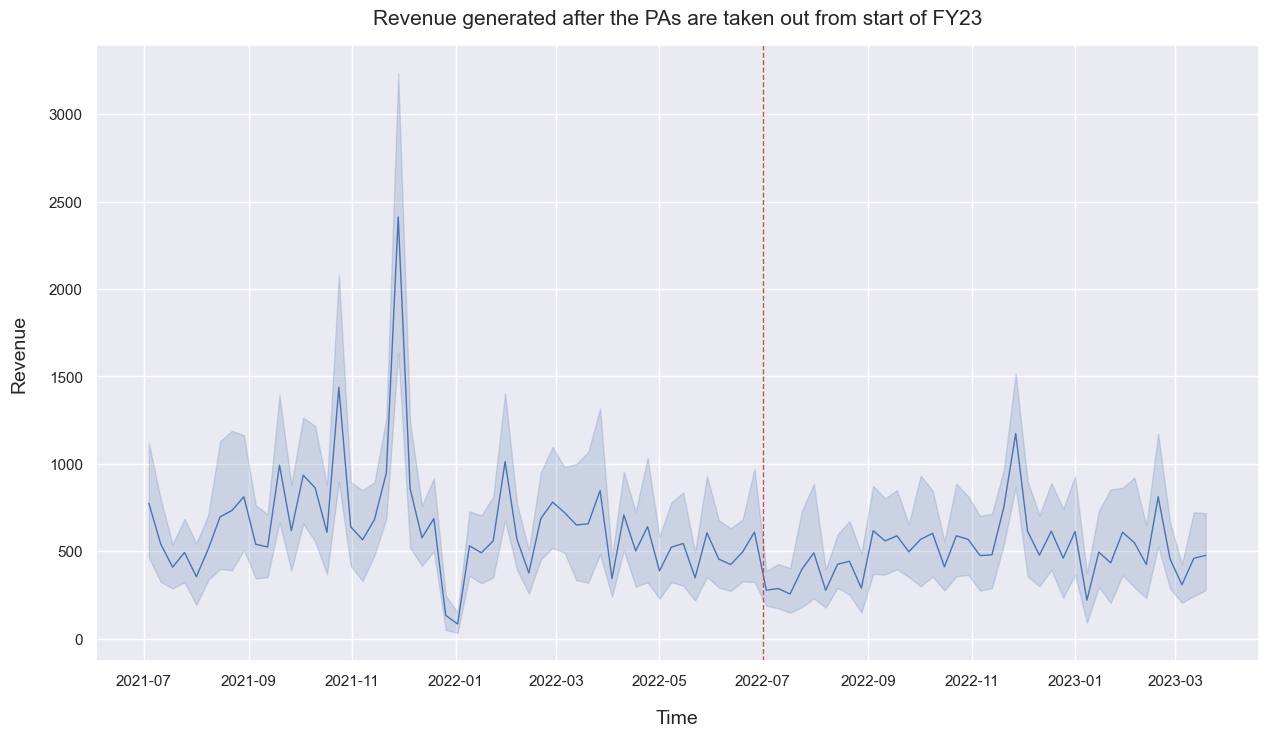

In [14]:
# Plot the bugs reported for the Web team during 2020.
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=df, x="Sales_Date", y='Rslr Sales Amount', linewidth=1)
s.set_title('Revenue generated after the PAs are taken out from start of FY23', y=1.02, fontsize=15)
s.set_xlabel('Time', fontsize=14, labelpad=15)
s.set_ylabel('Revenue', fontsize=14, labelpad=15)
plt.axvline(dt.datetime(2022,7, 1), color='r', linewidth=1, linestyle='--')
plt.show()

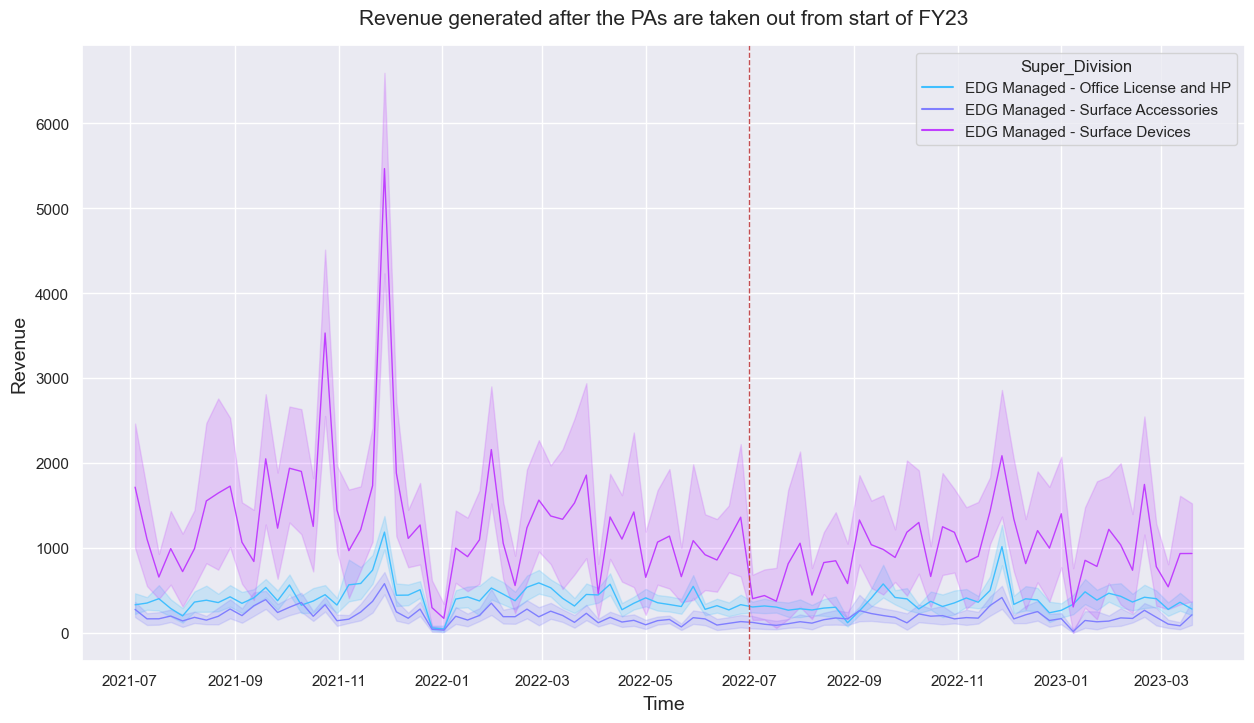

In [15]:
# Plot the bugs reported for all software engineering teams during 2020.
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=df, x="Sales_Date", y='Rslr Sales Amount', hue= 'Super_Division', linewidth=1, palette='cool')
s.set_title('Revenue generated after the PAs are taken out from start of FY23', y=1.02, fontsize=15)
s.set_xlabel('Time', fontsize=14, labelpad=5)
s.set_ylabel('Revenue', fontsize=14, labelpad=5)
plt.axvline(dt.datetime(2022,7, 1), color='r', linewidth=1, linestyle='--')
plt.show()

### Causal Inference
##### Causal inference is about determining the effect of an event or intervention on a desired outcome metric. It can also be thought of as determining whether a change in the outcome metric was caused by an event or intervention.

##### 1. Transform Dataset for Model

In [ ]:
# Convert the dataframe into a wide form using a pivot table.
df_piv = pd.pivot_table(df, values='Rslr Sales Amount', index='Sales_Date', columns='Super_Division', aggfunc=np.sum)

# Position the Web column as the first column. since it is our Y.  All other columns are our X.
df_piv = df_piv[['EDG Managed - Office License and HP', 'EDG Managed - Surface Devices', 'EDG Managed - Surface Accessories']]
df_piv.head()

In [ ]:
# Flatten the pivot table and set the index of the dataframe to the date column. 
df_flattened = pd.DataFrame(df_piv.to_records()).reset_index(drop=True)
df_flattened = df_flattened.set_index('Sales_Date')
df_flattened.head()

In [20]:
# Set the pre_period for the model to the dates prior to the delivery of training of the Web software
# engineering team, and the post_period to the datesafter the training.
from causalimpact import CausalImpact
pre_period = ['20210704', '20220703']
post_period = ['20220710', '20221225']

# Run the model and display the results.
ci = CausalImpact(df_flattened, pre_period, post_period)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


In [ ]:
ci.summary_data

In [22]:
pd.DataFrame(ci.summary_data).reset_index().loc[7,:].values[1]*100

-5.46025620561882

In [36]:
def main(data):
    
    stores = data['Outlet_ID'].unique().tolist()
    ci_data = pd.DataFrame()
    Actual_effect = {'Outlet_ID':[], 'Impact_percent':[]}

    for store in stores:
        store_data = data.loc[data['Outlet_ID'] == store].reset_index(drop=True)
        # Convert the dataframe into a wide form using a pivot table.
        df_piv = pd.pivot_table(store_data, values='Rslr Sales Amount', index='Sales_Date', aggfunc=np.sum)
        df_flattened = pd.DataFrame(df_piv.to_records()).reset_index(drop=True)
        df_flattened = df_flattened.set_index('Sales_Date')
        pre_period = ['20210704', '20220703']
        post_period = ['20220710', '20221225']
        # Run the model and display the results.
        ci = CausalImpact(df_flattened, pre_period, post_period)
        Casual_infer = pd.DataFrame(ci.inferences[['post_cum_y','post_cum_effects_means', 'point_effects_means']].reset_index()).reset_index(drop=True)
        Casual_infer['Outlet_ID'] = store
        Actual_effect['Outlet_ID'].append(store)
        Actual_effect['Impact_percent'].append(pd.DataFrame(ci.summary_data).reset_index().loc[7,:].values[1]*100)
        ci_data = pd.concat([ci_data, Casual_infer]).reset_index(drop=True)
    Actual_effect = pd.DataFrame(Actual_effect)

    Actual_effect['Impact_percent'] = np.where(Actual_effect['Impact_percent'] < 0, 0, Actual_effect['Impact_percent'])
    #ci_data['point_effects_means'] = np.where(ci_data['point_effects_means'] < 0, 0, ci_data['point_effects_means'])
    return ci_data, Actual_effect

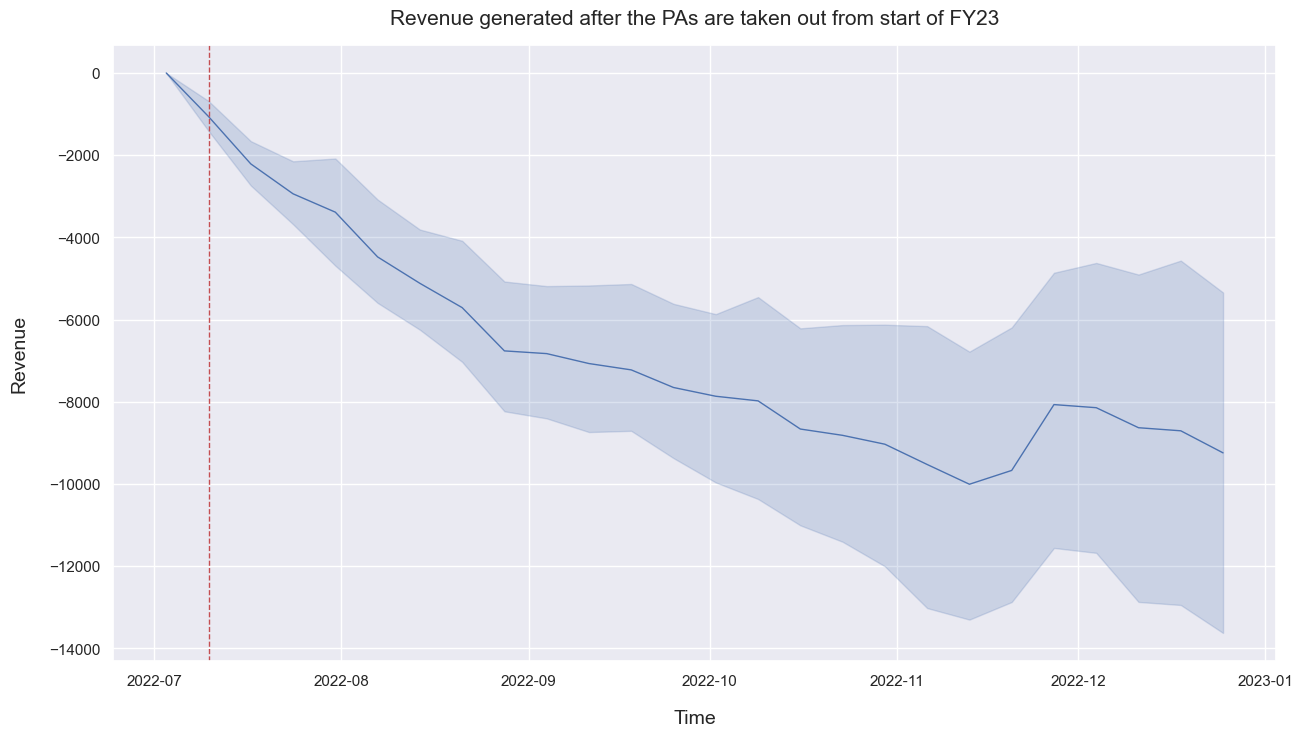

In [38]:
# Plot the bugs reported for the Web team during 2020.
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=ci_data, x="Sales_Date", y='post_cum_effects_means', linewidth=1)
s.set_title('Revenue generated after the PAs are taken out from start of FY23', y=1.02, fontsize=15)
s.set_xlabel('Time', fontsize=14, labelpad=15)
s.set_ylabel('Revenue', fontsize=14, labelpad=15)
plt.axvline(dt.datetime(2022,7, 10), color='r', linewidth=1, linestyle='--')
plt.show()

In [23]:
ci.inferences[['post_cum_y','post_cum_effects_means', 'point_effects_means']]

,post_cum_y,post_cum_effects_means,point_effects_means
Sales_Date,,,
2021-07-04,NaN,NaN,-1007.242676
2021-07-11,NaN,NaN,1636.333008
2021-07-18,NaN,NaN,1781.299805
2021-07-25,NaN,NaN,-805.102539
2021-08-01,NaN,NaN,-968.122559
...,...,...,...
2022-11-27,101680.0,-3918.244141,5047.831055
2022-12-04,106039.0,-4526.741699,-608.497559
2022-12-11,111261.0,-4552.526367,-25.784668


In [ ]:
ci.inferences[['post_cum_effects_means', 'post_cum_preds_means',  'post_cum_y', 'complete_preds_means', 'point_effects_means']]

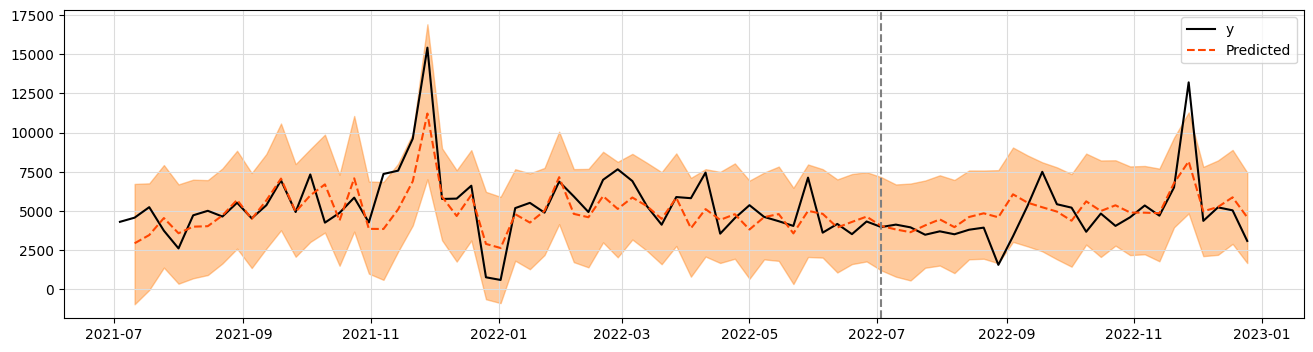

In [26]:
ci.plot(panels=['original'], figsize=(16,4))

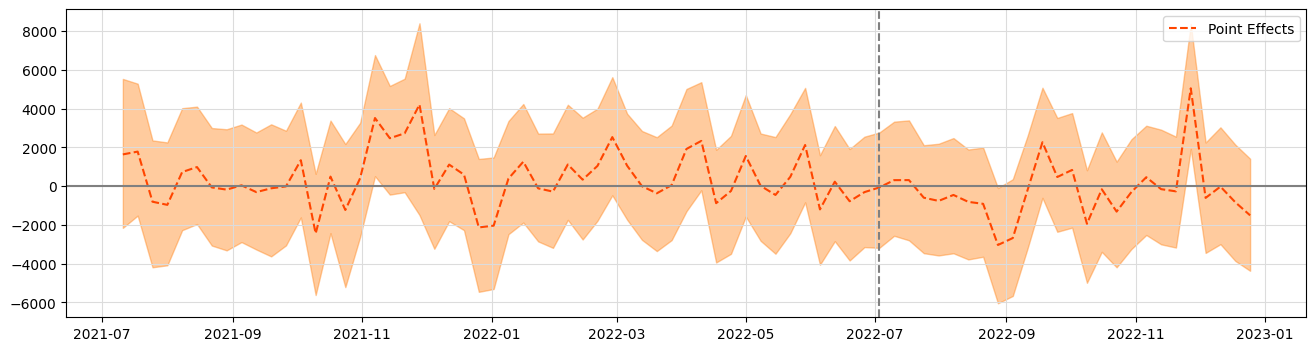

In [27]:
ci.plot(panels=['pointwise'], figsize=(16,4))

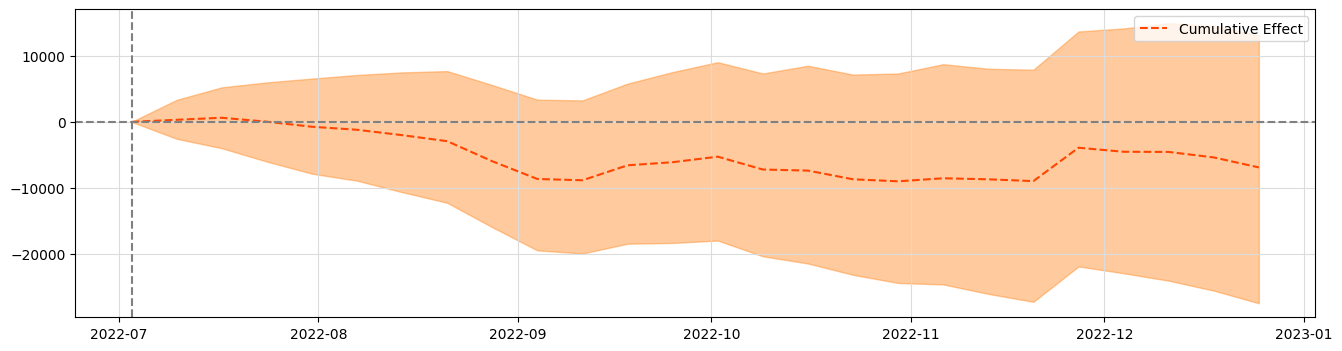

In [28]:
ci.plot(panels=['cumulative'], figsize=(16,4))

In [30]:
# Display model summary output.
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    4774.76            119369.0
Prediction (s.d.)         5050.53 (421.48)   126263.28 (10536.9)
95% CI                    [4233.69, 5885.84] [105842.16, 147146.06]

Absolute effect (s.d.)    -275.77 (421.48)   -6894.28 (10536.9)
95% CI                    [-1111.08, 541.07] [-27777.06, 13526.84]

Relative effect (s.d.)    -5.46% (8.35%)     -5.46% (8.35%)
95% CI                    [-22.0%, 10.71%]   [-22.0%, 10.71%]

Posterior tail-area probability p: 0.24
Posterior prob. of a causal effect: 76.42%

For more details run the command: print(impact.summary('report'))


### Short Breif about the summary 

The post-intervention period had an average response of 4844.06, which is lower than the expected average response of 5278.6 if there was no intervention. However, the causal effect of the intervention is not statistically significant, with an estimated effect of -434.54 and a 95% interval of [-1385.93, 450.94]. The overall response variable during the post-intervention period was 150166.0, lower than the expected value of 163636.64 without intervention. The relative decrease in the response variable was -8.23%, with a 95% interval of [-26.26%, 8.54%], which is also not statistically significant. The lack of significance may be due to random fluctuations, a too-short or too-long intervention period, insufficient control variables, or poor correlation between control variables and the response variable. The probability of obtaining this effect by chance is 17.38%.